# Variants of stochastic gradient-based optimization

## Steps

1. Setting the scene
2. Stochastic Gradient Descent (SGD)
3. SGD with adaptive learning rate
4. SGD with momentum 
5. SGD with accumulated squared gradient: AdaGrad
6. SGD with accumulated squared gradient: RMSProp
7. SGD with accumulated squared gradient: ADAM
8. SGD with Newton’s method
9. SGD with the conjugate gradient method

### Imports

In [51]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import matplotlib.lines as lines

## Setting the scene

During learning, we optimize the mean squared error $MSE$ of the models $m$ for the model parameters $\mathbf w$: 

$$MSE(\mathbf w,m,X,Y) =\frac{1}{N}\sum_{i=1}^{N}(y_i - m(\mathbf w, \mathbf  x_i))^2$$

In other words, we find $\arg\min_{\mathbf w} MSE(\mathbf w, m, X, Y)$.

We will reuse some functions defined in the notebook "Learn an XOR Neural Network using gradient-based optimization" including:
1. The mean squared error function `mse` (loss function).
2. The gradient of the mean squared error function `grad_mse` (gradient of the loss function).
3. The gradient descent function for the loss function `grad_desc_mse`.
4. The 3D surcace and contour plot function `plot3D`.

In [52]:
def mse(ws, m, X, Y):
    N = X.shape[0]
    err = 0;
    for i in range(N):
        xi=X[i,:]
        yi=m(ws,xi)
        err = err + (Y[i]-yi)**2;
    err = err/N;
    return err

def grad_mse(ws, m, grads, X, Y):
    N = X.shape[0]
    M = ws.shape[0]
    grad_ws = np.zeros(M)
    
    for i in range(N):
        xi = X[i,:]
        yi = Y[i]
        tmp = yi - m(ws,xi)
        for j in range(M):
            grad_ws[j] = grad_ws[j] + tmp * grads[j](ws,xi)
    grad_ws = -2/N*grad_ws;
    return grad_ws

def grad_desc_mse(K, ws, learning_eps, loss, grad_loss, verbose=False, ax=None):
    history = [ loss(ws) ]
    for k in range(K):
        grad_ws = grad_loss(ws)
        old_ws = ws
        ws = old_ws - learning_eps * grad_ws;
        history.append(loss(ws))
        if verbose:
            plt.plot([old_ws[0],ws[0]],[old_ws[1],ws[1]], c="b", linewidth=1)
    return ws, history

def plot3d(f, A, B, real3d=True):
    Z = arrayfun(f,A,B)
    if real3d:
        fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
        surf = ax.plot_surface(A, B, Z, cmap=cm.coolwarm, linewidth=0, antialiased=False)
    else:
        cs = plt.contour(A,B,Z)
        plt.clabel(cs, inline=True, fontsize=9)
#     return Z, fig, ax
    
def arrayfun(f,A,B):
    Z = np.zeros(A.shape)
    for row in range(A.shape[0]):
        for col in range(A.shape[1]):
            Z[row,col] = f(A[row,col],B[row,col])
    return Z

def arrayfun3(f,A,B,C):
    Z = np.zeros(A.shape)
    for i in range(A.shape[0]):
        Z[i] = f(A[i],B[i],C[i])
    return Z

def fullfact(levels):
    """
    @Author: https://github.com/tisimst/pyDOE/blob/436143702507a5c8ff87b361223eee8171d6a1d7/pyDOE/doe_factorial.py
    """
    n = len(levels)  # number of factors
    nb_lines = np.prod(levels)  # number of trial conditions
    H = np.zeros((nb_lines, n))
    
    level_repeat = 1
    range_repeat = np.prod(levels)
    for i in range(n):
        range_repeat //= levels[i]
        lvl = []
        for j in range(levels[i]):
            lvl += [j]*level_repeat
        rng = lvl*range_repeat
        level_repeat *= levels[i]
        H[:, i] = rng
     
    return H

First we generate sample data points. The generator function is $y=20x_1 -3x_2$. We sample data at integer points $x_{i,1}\times x_{i,2} \in [1\ldots N]\times [1\ldots N], N=100$ and add a random error to $y_i$ that is normally distributed proportional to $\mathcal{N}(0,10)$. 

Below we plot the function.

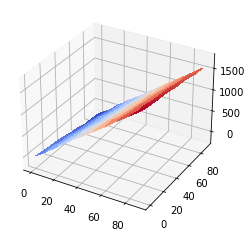

In [53]:
rng = np.random.default_rng(3)

N=100 # N=1000;

XX = np.fliplr(fullfact([N,N]));
a10 = 20
a20 = -3 
X1 = XX[:,0]
X2 = XX[:,1]

f0 = lambda x1,x2: a10*x1 + a20*x2
f = lambda x1,x2,r: a10*x1 + a20*x2 + r
R = rng.normal(0, 1, (1,N*N)).T
Y = arrayfun3(f,X1,X2,R)
interval = np.arange(0,N,N/10)
A,B = np.meshgrid(interval, interval)
ff = lambda x1,x2: f(x1,x2,rng.normal(0, 10))
plot3d(ff,A,B)

The model that we use throughout this notebook is a simple linear Neural Network model. It consists of one neuron connected to the input $\mathbf x$ and an identity, i.e., no effective, activation function. The neuron and the whole model $m_1$ implements $m_1(\mathbf w, \mathbf x) = \mathbf w^T \mathbf x$.

In [54]:
m1 = lambda ws,x: ws[0]*x[0] + ws[1]*x[1]
mse1 = lambda ws: mse(ws,m1,XX,Y)

As the Tensorflow default, we implement the Glorot uniform initializer for setting the initial weights $\mathbf w_0$.
It draws samples from a uniform random distribution within $[-\mathit{limit}, \mathit{limit}]$,
where $\mathit{limit} = \sqrt{\frac{6}{\mathit{in} + \mathit{out}}}$, and
where $\mathit{in}$ and $\mathit{out}$ is the number of input and output units, resp.

In [55]:
_in = 2;
out = 1;
limit = np.sqrt(6 / (_in + out))
ws0 = np.array([rng.uniform()*2*limit-limit, rng.uniform()*2*limit-limit])
print(ws0)

[0.23791112 0.3523239 ]


We assess the loss $MSE$ of $m_1$ for this initial weights setting.

In [56]:
mse1(ws0)

994568.9221731804

The gradient of $MSE(\mathbf w)$ for any $\mathbf w$ is defiend as:

$$
\begin{aligned}
\nabla_{MSE}(\mathbf w) &= \left [ 
\frac{\partial MSE(\mathbf w)}{\partial w_1},
\frac{\partial MSE(\mathbf w)}{\partial w_2}
\right ]^T\\
&= \frac{1}{N}\left [ 
\frac{\partial \sum_{i=1}^{N}(y_i - m_1(\mathbf w,\mathbf x_i)^2}{\partial w_1}, 
\frac{\partial \sum_{i=1}^{N}(y_i - m_1(\mathbf w,\mathbf x_i))^2}{\partial w_2} 
\right ]^T \\
&= \frac{1}{N} \left [ 
\sum_{i=1}^{N}2(y_i- m_1(\mathbf w,\mathbf x_i))\frac{-\partial m_1(\mathbf w,\mathbf x_i)}{\partial w_1},
\sum_{i=1}^{N}2(y_i- m_1(\mathbf w,\mathbf x_i))\frac{-\partial m_1(\mathbf w,\mathbf x_i)}{\partial w_2}
\right ]^T \\
&= -\frac{2}{N} \left [ 
\sum_{i=1}^{N}(y_i- m_1(\mathbf w,\mathbf x_i))\frac{\partial m_1(\mathbf w,\mathbf x_i)}{\partial w_1},
\sum_{i=1}^{N}(y_i- m_1(\mathbf w,\mathbf x_i))\frac{\partial m_1(\mathbf w,\mathbf x_i)}{\partial w_2}
\right ]^T \\
\end{aligned}
$$

We can plug in the function $m_1$ and the first derivative of $m_1$ wrt. $w_1$ and $w_2$ resp.

$$
\begin{aligned}
\frac{\partial m_1(\mathbf w,\mathbf x_i)}{\partial w_1} &=\frac{\partial \mathbf w^T\mathbf x_{i}}{\partial w_1} = \frac{\partial w_1 x_{i,1} + w_2 x_{i,2}}{\partial w_1}  =x_{i,1}\\
\frac{\partial m_1(\mathbf w,\mathbf x_i)}{\partial w_2} &=\frac{\partial \mathbf w^T\mathbf x_{i}}{\partial w_2} = \frac{\partial w_1 x_{i,1} + w_2 x_{i,2}}{\partial w_2}  = x_{i,2}\\
\end{aligned}
$$

We have already defined the function $m_1$. Let's also define the functions of the first derivative of $m_1$ wrt. $w_1$ and $w_2$ resp. For the sake of generality, we keep $\mathbf w$ as a formal parameter `ws` even though it is actually not needed for  derivatives of this concrete model $m_1$. 

In [57]:
gradients1 = [lambda ws,x: x[0], lambda ws,x: x[1]]

The gradient $\nabla_{MSE}(\mathbf w)$ has been defined using $m_1$ and the first derivative of $m_1$ wrt. $w_1$ and $w_2$, resp., as parameters.

The gradient descent function optimizes $\mathbf w$ by iterating over:

$$\mathbf w_{k+1}= \mathbf w_k - \varepsilon \nabla_{MSE}(\mathbf w_k)$$

staring with $\mathbf w_0$.

Below we apply the gradient descent function minimizing $MSE$ for the model $m_1$. We plot the $MSE$ for each step $k$ in the iteration as a function of the current parameter setting $\mathbf w_k$. We also marked the starting point $\mathbf w_0$ with a `+` and the (ideal) minimum $(20, -3)$ with a `*`.

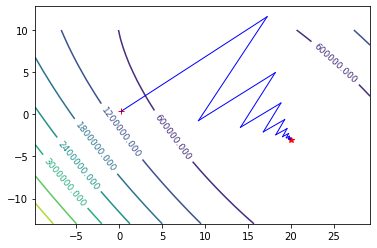

In [58]:
# plot search space
f = lambda a, b: mse1([a,b]) # convert to np array?

# hold on
plt.plot(a10,a20,'*r')
plt.plot(ws0[0],ws0[1],'+r')

# # gradient descent
grad_loss = lambda ws: grad_mse(ws, m1, gradients1, XX, Y)
K = 20; 
learning_eps = 0.00015; 

ws, history = grad_desc_mse(K, ws0, learning_eps, mse1, grad_loss, True);
interval   = np.arange( np.minimum(a10,ws0[0])-10, np.maximum(a10,ws0[0])+10, 1 )
interval2  = np.arange( np.minimum(a20,ws0[1])-10, np.maximum(a20,ws0[1])+10, 1 )
A,B = np.meshgrid(interval, interval2)
plot3d(f, A, B, False) #3D contour

plt.show()

The history plot shows the convergence of the algorithm. After ca. $k=15$ iterations, the loss $MSE$ is almost zero. 

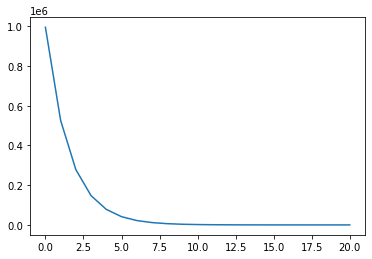

In [59]:
plt.plot(range(len(history)),history)
plt.show()

## Stochastic Gradient Descent (SGD)

SGD works like the gradient descent but computes the gradient based on a mini batch of size $m \ll N$. Therefore, our SGD implementation `stochastic_grad_desc_mse` generates in each iteration an array `randices`, i.e., random indices  making up the current mini batch sample of the whole data set. We resample this array in each iteration of the SGD algorithm.

We also define a corresponding `grad_mse2` function that computes the gradient only based on the mini batch data points. 

In [60]:
def stochastic_grad_desc_mse(K, ws, learning_eps, loss, grad_loss, N, verbose=False):
    batch_size = int(N*0.01)
    history = [ loss(ws) ]
    for k in range(K):
        randices = rng.choice(N,batch_size)#randsample(1:N,batch_size,false);
        grad_ws = grad_loss(ws, randices)
        old_ws = ws;
        ws = old_ws - learning_eps * grad_ws
        if verbose:
            plt.plot([old_ws[0],ws[0]],[old_ws[1],ws[1]], c="b", linewidth=1)
        history.append(loss(ws))
    return ws, history

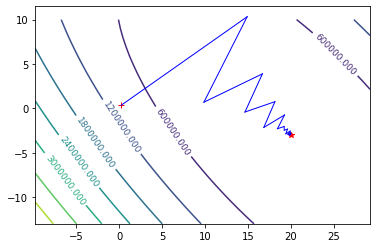

In [61]:
# plot search space
plot3d(f, A, B, False) # 3D contour
# hold on
plt.plot(a10,a20,'*r')
plt.plot(ws0[0],ws0[1],'+r')

# stochastic gradient descent
grad_loss2 = lambda ws, randices: grad_mse(ws, m1, gradients1, XX[randices,:],Y[randices])
# tic;
ws, history = stochastic_grad_desc_mse(K, ws0, learning_eps, mse1, grad_loss2, N*N, True);
# toc

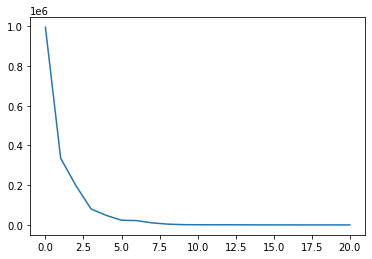

In [62]:
plt.plot(range(len(history)),history)
plt.show()

## SGD with adaptive learning rate

The learning rate $\varepsilon$ is adapted in each iteration, e.g., exponentially by $\varepsilon_{k+1} = (1-\alpha)\varepsilon_{k}$ with $\alpha$ a new hyper-parameter. 

In [63]:
def stochastic_adaptive_grad_desc_mse(K, ws, learning_eps, loss, grad_loss, N, alpha, verbose=False):
    batch_size = int(N*0.01)
    history = [loss(ws)]
    for k in range(K):
        randices = rng.choice(N,batch_size)
        grad_ws = grad_loss(ws, randices)
        old_ws = ws
        ws= old_ws - learning_eps * grad_ws
        learning_eps = (1-alpha) * learning_eps
        if verbose:
            plt.plot([old_ws[0],ws[0]],[old_ws[1],ws[1]], c="b", linewidth=1)
        history.append(loss(ws))
    return ws, history

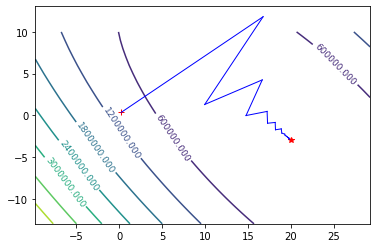

In [64]:
# plot search space
plot3d(f, A, B, False) #3D contour
plt.plot(a10,a20,'*r')
plt.plot(ws0[0],ws0[1],'+r')

# stochastic adaptive gradient descent
alpha = 0.03;
ws, history = stochastic_adaptive_grad_desc_mse(K, ws0, learning_eps, mse1, grad_loss2, N*N, alpha, True);

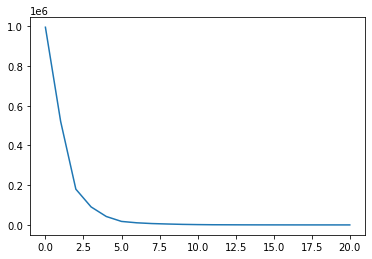

In [65]:
plt.plot(range(len(history)),history)
plt.show()

## SGD with momentum 

The gradient can be understood as a velocity at which we move towards the optimum. In this analogy, momentum $p$ is introduced as the velocity $v$ (gradient) times mass $m$, a new hyper-parameter of the algorithm. The velocity is set to the exponentially decaying moving average of past gradients. The initial velocity $v_0$ is the initial gradient. 

**OBS!** The velocity (earlier gradient vectors) and the current gradient vector point "uphill", i.e, into the inverse direction of the expected minimum. They should, hence, be **both** subtracted from the current parameters. 

In [66]:
def stochastic_momentum_grad_desc_mse(K, ws, learning_eps, loss, grad_loss, N, mass, verbose):
    batch_size = int(N*0.01)
    history = [loss(ws)]
    v = 0
    for k in range(K):
        randices = rng.choice(N,batch_size)
        grad_ws = grad_loss(ws, randices)
        v = (v+grad_ws)/2
        old_ws = ws
        ws = old_ws - mass * v - learning_eps * grad_ws
        if verbose:
            plt.plot([old_ws[0],ws[0]],[old_ws[1],ws[1]], c="b", linewidth=1)
        history.append(loss(ws))
    return ws, history

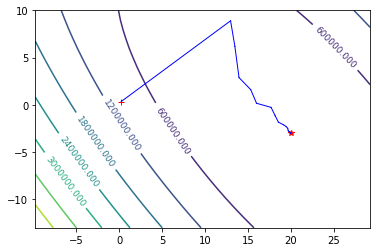

In [67]:
# plot search space
plot3d(f, A, B, False) #3D contour
plt.plot(a10,a20,'*r')
plt.plot(ws0[0],ws0[1],'+r')

# stochastic momentum gradient descent
mass = 1/2 * 0.00015
learning_eps = 1/2 * 0.00015
ws, history = stochastic_momentum_grad_desc_mse(K, ws0, learning_eps, mse1, grad_loss2, N*N, mass, True)

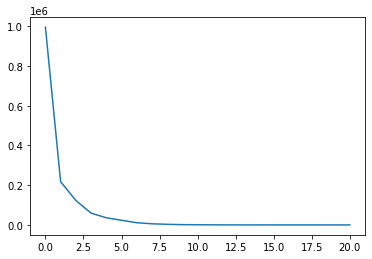

In [68]:
plt.plot(range(len(history)),history)
plt.show()

## SGD with accumulated squared gradient: AdaGrad

With AdaGrad, each parameter has its own learning rate.
This learning rate is always decreasing, but faster for the parameters with the larger gradients. The derease is quite fast, so we have to adapt the constant component $\varepsilon$ of the learning rate.

In [69]:
def ada_grad_mse(K, ws, learning_eps, loss, grad_loss, N, verbose):
    batch_size = int(N*0.01)
    history = [loss(ws)]
    r = np.zeros(len(ws))
    delta = 1e-10*np.ones(len(ws))
    for k in range(K):
        randices = rng.choice(N,batch_size)
        grad_ws = grad_loss(ws, randices)
        old_ws = ws
        r = r + grad_ws * grad_ws
        ws = old_ws - learning_eps/(delta+np.sqrt(r)) * grad_ws
        if verbose:
            plt.plot([old_ws[0],ws[0]],[old_ws[1],ws[1]], c="b", linewidth=1)
        history.append(loss(ws))
    return ws, history

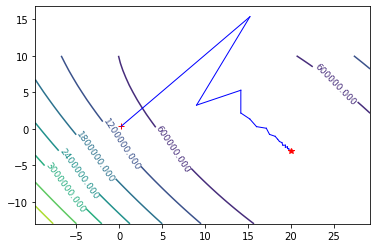

In [70]:
# plot search space
plot3d(f, A, B, False) #3D contour
plt.plot(a10,a20,'*r')
plt.plot(ws0[0],ws0[1],'+r')

# AdaGrad
learning_eps = 15;
ws, history = ada_grad_mse(K, ws0, learning_eps, mse1, grad_loss2, N*N, True)


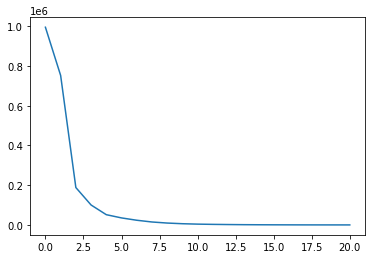

In [71]:
plt.plot(range(len(history)),history)
plt.show()

## SGD with accumulated squared gradient: RMSProp

RMSProp adds a hyper-parameter $\rho \in [0\ldots 1]$ to AdaGrad. It biases between the accumulated squared gradients $r$, i.e., the historic (squared) velocity, and the current squared gradient before deviding the learning rate by $\sqrt{r}$.

In [72]:
def rms_prob_mse(K, ws, learning_eps, loss, grad_loss, N, rho, verbose):
    batch_size = int(N*0.01)
    history = [loss(ws)]
    r = np.zeros(len(ws))
    delta = 1e-10*np.ones(len(ws))
    for k in range(K):
        randices = rng.choice(N,batch_size)
        grad_ws = grad_loss(ws, randices)
        old_ws = ws
        r = rho*r + (1-rho) * grad_ws * grad_ws
        ws = old_ws - learning_eps/(delta+np.sqrt(r)) * grad_ws
        if verbose:
            plt.plot([old_ws[0],ws[0]],[old_ws[1],ws[1]], c="b", linewidth=1)
        history.append(loss(ws))
    return ws, history

For RMSProb, it was hard to find good hyper-parameters just by trying out a few. Here the loss for different hyper-parameter settings of $\rho \in [0\ldots 1]$ and $\varepsilon \in [1\ldots 20]$. We finally chose the setting with the minimum loss after 20 iterations: $\varepsilon = 1, \rho=0.98$. Note, that we needed to increase the number of iterations to arrive at a the ideal parameters. So, for this simplistic setup, RMSProb did not speed up convergence.

![title](img/rms_prob_hyperparameters.png)

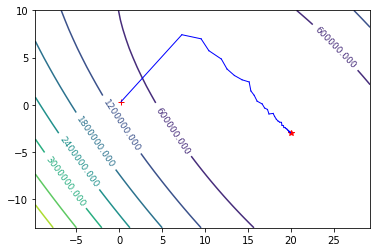

In [73]:
# plot search space
plot3d(f, A, B, False) #3D contour
plt.plot(a10,a20,'*r')
plt.plot(ws0[0],ws0[1],'+r')

# RMSProb
learning_eps = 1;
rho = 0.98;
K = 40;
ws, history = rms_prob_mse(K, ws0, learning_eps, mse1, grad_loss2, N*N, rho, True)


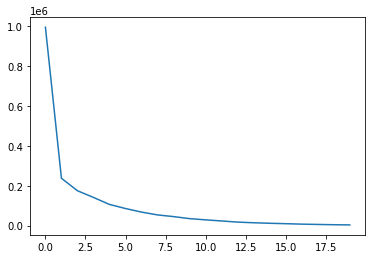

In [74]:
plt.plot(range(20),history[:20])
plt.show()

## SGD with accumulated squared gradient: ADAM

ADAM seems to be the current choice of many. However, it hasn't been trivial to choose the learning rate and the two hyper-parameters $\rho_1, \rho_2$. We even needed to increase the number of iterations to arrive at a the ideal parameters. So, for this simplistic setup, ADAM did not speed up convergence.

In [75]:
def adam_mse(K, ws, learning_eps, loss, grad_loss, N, rho1, rho2, verbose):
    batch_size = int(N*0.01)
    history = [loss(ws)]
    s = np.zeros(len(ws))
    r = np.zeros(len(ws))
    t = 0
    delta = 1e-10*np.ones(len(ws))
    for k in range(K):
        randices = rng.choice(N,batch_size)
        grad_ws = grad_loss(ws, randices)
        old_ws = ws
        t = t +1
        s = rho1*s + (1-rho1) * grad_ws;
        r = rho2*r + (1-rho2) * grad_ws * grad_ws;
        s_hat = s/(1-rho1**t)
        r_hat = r/(1-rho2**t)
        ws= old_ws - (learning_eps*s_hat)/(delta+np.sqrt(r))
        if verbose:
            plt.plot([old_ws[0],ws[0]],[old_ws[1],ws[1]], c="b", linewidth=1)
        history.append(loss(ws))
    return ws, history

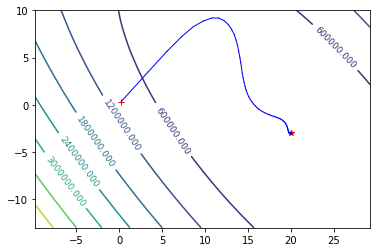

In [76]:
# plot search space
plot3d(f, A, B, False) #3D contour
plt.plot(a10,a20,'*r')
plt.plot(ws0[0],ws0[1],'+r')

#  ADAM; 
learning_eps = 0.1
rho1 = 0.9
rho2 = 0.999
K=400 # !!
ws, history = adam_mse(K, ws0, learning_eps, mse1, grad_loss2, N*N, rho1, rho2, True)


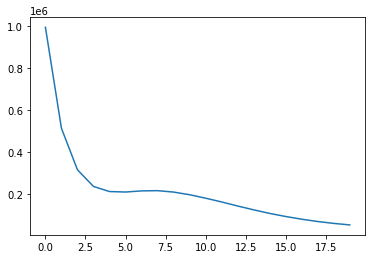

In [77]:
plt.plot(range(20),history[:20])
plt.show()

## SGD with Newton’s method 

It is obviously difficult to set the learning rate (and the other parameters) right. To help this, Newton's method (and other second order methods) involve the second order derivatives, e.g., the Hessian matrix $H_{MSE}$. Then they iterate:

$$
\mathbf w_{k+1} = \mathbf w_k - H_{MSE}(\mathbf w_k)^{-1} \nabla_{MSE}(\mathbf w_k) 
$$

where $H_{MSE}$ is the Hessian matrix of $MSE$. 

$H_{MSE}$ is defined as:
$$
\begin{aligned}
H_{MSE}(\mathbf w) &= 
\begin{bmatrix}
\frac{\partial^2 MSE(\mathbf w)}{\partial w_1^2} & \frac{\partial^2 MSE(\mathbf w)}{\partial w_1 \partial w_2} \\
\frac{\partial^2 MSE(\mathbf w)}{\partial w_2 \partial w_1} & \frac{\partial^2 MSE(\mathbf w)}{\partial w_2^2} 
\end{bmatrix}\\
&=
\frac{-2}{N}
\begin{bmatrix}
\frac{\partial (\sum_{i=1}^{N}(y_i- m_1(\mathbf w, \mathbf x_i)x_{i,1})}{\partial w_1} & 
\frac{\partial (\sum_{i=1}^{N}(y_i- m_1(\mathbf w, \mathbf x_i)x_{i,1})}{\partial w_2} \\
\frac{\partial (\sum_{i=1}^{N}(y_i- m_1(\mathbf w, \mathbf x_i)x_{i,2})}{\partial w_1} & 
\frac{\partial (\sum_{i=1}^{N}(y_i- m_1(\mathbf w, \mathbf x_i)x_{i,2})}{\partial w_2} \\
\end{bmatrix}\\
&=
\frac{2}{N}
\begin{bmatrix}
\sum_{i=1}^{N}x_{i,1}^2 & \sum_{i=1}^{N}x_{i,1}x_{i,2} \\
\sum_{i=1}^{N}x_{i,1}x_{i,2} & \sum_{i=1}^{N} x_{i,2}^2
\end{bmatrix}\\
\end{aligned}
$$

This approach generalizes easily to a stochastic version of Newtons method using only a sample of the training data of size $m \ll N$.

In [93]:
def hessian_mse(ws, X):
    N = len(X)
    M = len(ws)
    H = np.zeros((M,M))
    for r in range(M):
        for c in range(M):
            for i in range(N):
                H[r,c] = H[r,c] + X[i,r]*X[i,c]
    H = 2/N*H;
    return H

In [94]:
grad2_loss = lambda ws, randices: hessian_mse(ws, XX[randices,:])

In [95]:
def stochastic_newton_mse(K, ws, loss, grad_loss, grad2_loss, N, verbose):
    batch_size = int(N*0.01)
    history = [loss(ws)]
    for k in range(K):
        randices = rng.choice(N,batch_size)
        grad_ws = grad_loss(ws, randices)
        old_ws = ws
        H = grad2_loss(ws, randices)
        ws = old_ws - np.linalg.inv(H) @ grad_ws
        if verbose:
            plt.plot([old_ws[0],ws[0]],[old_ws[1],ws[1]], c="b", linewidth=1)
        history.append(loss(ws))
    return ws, history

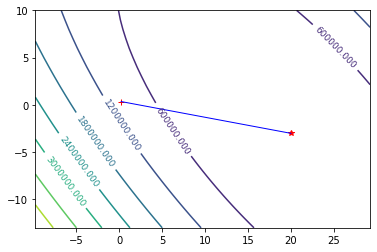

In [96]:
# plot search space
plot3d(f, A, B, False) #3D contour
plt.plot(a10,a20,'*r')
plt.plot(ws0[0],ws0[1],'+r')

#  Newton's method
K=1 # !!!
ws, history = stochastic_newton_mse(K, ws0, mse1, grad_loss2, grad2_loss, N*N, True)

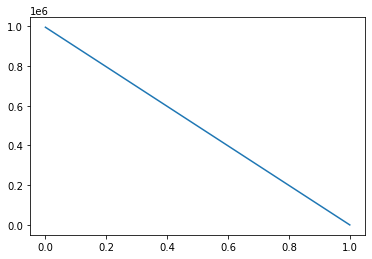

In [97]:
plt.plot(range(len(history)),history)
plt.show()

## SGD with the conjugate gradient method

The Hessian is quite large, with a size $O(n^2)$ for $n$ parameters, and needs to be updated in each iteration. The conjugate gradient method tries to avoid the explicite calculation of the Hessian. 

Part of the algorithm is a search along the (adjusted) gradient line for the optimum (lowest loss) point on this line. Therefore, we would like to use the mini batch instead of the whole training data set. We define a stochastic loss function accordingly.  

In [106]:
mse2 = lambda ws, randices: mse(ws,m1,XX[randices,:],Y[randices])

In *linear* conjugate gradient descent, we search along the gradient line for the point to adjust the parameters to. For *non-linear* conjugate gradient descent, we adjust the gradient line before this linear search based on the gradients' history. 

**OBS!** For non-linear conjugate gradient descent, the gradient line adjustment (actually computing its scaling factor $\beta$) in iteration $k$ requires the gradient of iteration $k-1$. This gradient is not available in the first iteration. Therefore, we need to do a linear conjugate gradient descent in the first iteration. 

In [107]:
def cg_mse(K, ws, loss, stochastic_loss, grad_loss, N, verbose):
    # initialization
    batch_size = int(N*0.01)
    history = [loss(ws)]
    # we only need variables at t (var) and t-1 (var_old) 
    rho_old = np.zeros(len(ws))
    grad_ws_old = np.zeros(len(ws))
    
    for k in range(K):
        randices = rng.choice(N,batch_size)
        # Compute gradient
        grad_ws = grad_loss(ws, randices)
        if k==1:
            # Linear cg, i.e., no search direction adjustment in the first round
            rho = - grad_ws
        else:
            # Compute Polak-Ribière
            beta = ( np.conj((grad_ws - grad_ws_old).T) * grad_ws) / ( np.conj(grad_ws_old.T) * grad_ws_old)
            # Compute search direction
            rho = - grad_ws + beta@rho_old
        # Naive line search for epsilon* = argmin stochastic_loss(ws+epsilon * rho)
        epsilon_star = 0.00001
        minimum_star = stochastic_loss(ws+epsilon_star*rho,randices)
        _range = np.arange(0.00001, 1, 0.0001)
        for epsilon in _range:
            minimum = stochastic_loss(ws+epsilon*rho,randices)
            if minimum < minimum_star:
                epsilon_star = epsilon
                minimum_star = minimum
        # Remember parameters (for drawing the line of this step if verbose) 
        old_ws = ws
        # Update the parameters
        ws = old_ws + epsilon_star * rho
        # Remember the variables at t as the old variables at t-1 in the next iteration 
        rho_old = rho
        grad_ws_old = grad_ws
        # Draw the line 
        if verbose:
            plt.plot([old_ws[0],ws[0]],[old_ws[1],ws[1]], c="b", linewidth=1)
        history.append(loss(ws))
    return ws, history

/Library/www/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in true_divide
/Library/www/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in matmul


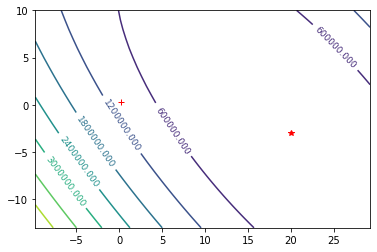

In [108]:
# plot search space
plot3d(f, A, B, False) #3D contour
plt.plot(a10,a20,'*r')
plt.plot(ws0[0],ws0[1],'+r')

# CG
K=20
ws, history = cg_mse(K, ws0, mse1, mse2, grad_loss2, N*N, True)


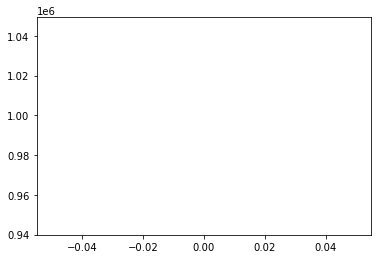

In [109]:
plt.plot(range(len(history)),history)
plt.show()

The line search that we implemented naïvely in the above algorithm is actually an optimization problem. Since, we only have one variable $\varepsilon$ to optimize for, we could use the quickly converging Newton method to implement this optimization. 

Substituting $\mathbf w \rightarrow \mathbf w + \varepsilon\boldsymbol{\rho}$, we seek to find $\varepsilon^* = \arg\min_{\varepsilon} MSE(\mathbf w + \varepsilon\boldsymbol{\rho},m,X,Y)$. This leads to the following function to optimize:

$$MSE^*(\varepsilon,\mathbf w,\boldsymbol{\rho},m,X,Y) =\frac{1}{N}\sum_{i=1}^{N}(y_i - m(\mathbf w+\varepsilon\boldsymbol{\rho}, \mathbf  x_i))^2$$

Recall, that only $\varepsilon$ is a variable in this function; all others are constant.

To apply Newton's method, we find the first and second derivations of $MSE^*$:

The gradient of $MSE^*(\varepsilon)$ is:

$$
\begin{aligned}
\nabla_{MSE^*}(\varepsilon) &= \frac{\partial MSE^*(\varepsilon)}{\partial \varepsilon}\\
&= \frac{1}{N}
\frac{\partial \sum_{i=1}^{N}(y_i - m_1(\mathbf w + \varepsilon\boldsymbol{\rho},\mathbf x_i))^2}{\partial \varepsilon}\\
&= \frac{1}{N}  
\sum_{i=1}^{N}2(y_i- m_1(\mathbf w + \varepsilon\boldsymbol{\rho},\mathbf x_i))\frac{-\partial m_1(\mathbf w + \varepsilon\boldsymbol{\rho},\mathbf x_i)}{\partial \varepsilon}\\
&= -\frac{2}{N} 
\sum_{i=1}^{N}(y_i- m_1(\mathbf w + \varepsilon\boldsymbol{\rho},\mathbf x_i))\frac{\partial m_1(\mathbf w + \varepsilon\boldsymbol{\rho},\mathbf x_i)}{\partial \varepsilon}\\
\end{aligned}
$$

We can plug in the function $m_1$ and the first derivation of $m_1$ to $\varepsilon$.

$$
\begin{aligned}
\frac{\partial m_1(\mathbf w + \varepsilon\boldsymbol{\rho},\mathbf x_i)}{\partial \varepsilon} &=\frac{\partial (\mathbf w + \varepsilon\boldsymbol{\rho})^T\mathbf x_{i}}{\partial \varepsilon} = \frac{\partial (\mathbf w^T \mathbf x_{i} + \varepsilon\boldsymbol{\rho}^T\mathbf x_{i})}{\partial \varepsilon}  =\boldsymbol{\rho}^T\mathbf x_{i}\\
\end{aligned}
$$

The second derivation of $MSE^*(\varepsilon)$ is:

$$
\begin{aligned}
h_{MSE^*}(\varepsilon) &= \frac{\partial^2 MSE^*(\varepsilon)}{\partial \varepsilon^2}\\
&= -\frac{2}{N} 
\frac{\partial \sum_{i=1}^{N}(y_i- m_1(\mathbf w + \varepsilon\boldsymbol{\rho},\mathbf x_i))\boldsymbol{\rho}^T\mathbf x_{i}}{\partial \varepsilon}\\
&= -\frac{2}{N} 
\frac{\partial \sum_{i=1}^{N}(y_i- (\mathbf w^T \mathbf x_i + \varepsilon\boldsymbol{\rho}^T\mathbf x_i))\boldsymbol{\rho}^T\mathbf x_{i}}{\partial \varepsilon}\\
&= \frac{2}{N} 
\sum_{i=1}^{N}(\boldsymbol{\rho}^T\mathbf x_{i})^2\\
\end{aligned}
$$

In [ ]:
%%file grad_eps.m
function grad_eps = grad_eps(eps, ws, rho, m, X, Y)
    N = length(X);
    grad_eps = 0;
    for i=1:N
        xi = X(i,:);
        yi = Y(i);
        tmp = yi - m(ws+eps*rho, xi);
        grad_eps = grad_eps + tmp*(rho'*xi');
    end
    grad_eps = -2/N*grad_eps;
end

In [ ]:
stochastic_grad_eps = @(eps, ws, rho, randices)(grad_eps(eps, ws, rho, m1, XX(randices,:), Y(randices)));

In [ ]:
%%file grad2_eps.m
function grad2_eps = grad2_eps(rho, X)
    N = length(X);
    grad2_eps = 0;
    for i=1:N
        xi = X(i,:);
        tmp = rho'*xi';
        grad2_eps = grad2_eps + tmp^2;
    end
    grad2_eps = 2/N*grad2_eps;
end

In [ ]:
stochastic_grad2_eps = @(rho, randices)(grad2_eps(rho, XX(randices,:)));

In [ ]:
%%file cg_mse_newton.m
function [ws, history] = cg_mse_newton(K, ws, loss, grad_loss, stochastic_grad_eps, stochastic_grad2_eps, N, verbose)
    %initialization
    batch_size = N*0.01;
    history(1) = loss(ws);
    %we only need variables at t (var) and t-1 (var_old) 
    rho_old = zeros(length(ws),1);
    grad_ws_old = zeros(length(ws),1);
    
    for k = 1:K
        randices = randsample(1:N,batch_size,false);
        %Compute gradient
        grad_ws = grad_loss(ws, randices);
        if k==1
            %Linear cg, i.e., no search direction adjustment in the first round
            rho = - grad_ws;
        else
            %Compute Polak-Ribière
            beta = ((grad_ws - grad_ws_old)' * grad_ws) /(grad_ws_old' * grad_ws_old);
            %Compute search direction
            rho = - grad_ws + beta*rho_old;
        end
        %Newton line search for epsilon* = argmin stochastic_loss(ws+epsilon * rho)
        %Just one iteration as the (stochastic) loss function is quadratic in epsilon
        epsilon_star = 0.5;
        grad_eps = stochastic_grad_eps(epsilon_star, ws, rho, randices);
        h = stochastic_grad2_eps(rho, randices);
        epsilon_star = epsilon_star - grad_eps/h;

        %Remember parameters (for drawing the line of this step if verbose) 
        old_ws = ws;
        %Update the parameters
        ws= old_ws + epsilon_star * rho;
        %Remember the variables at t as the old variables at t-1 in the next iteration 
        rho_old = rho;
        grad_ws_old = grad_ws;
        %Draw the line 
        if verbose
            line([old_ws(1),ws(1)],[old_ws(2),ws(2)]);
        end
        history(k+1) = loss(ws);
    end
end

In [ ]:
%% plot search space
plot3d(f, A, B, false) %3D contour
hold on
plot(a10,a20,'*r')
plot(ws0(1),ws0(2),'+r')

%% CG w Newton's method
K=20;
tic;
[ws, history] = cg_mse_newton(K, ws0, mse1, grad_loss2, stochastic_grad_eps, stochastic_grad2_eps, N*N, true);
toc

In [ ]:
plot(1:length(history),history)